##### 1.載入套件與全域變數設定

In [1]:
import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, precision_recall_curve, auc)
from scipy.stats import zscore
from imblearn.over_sampling import SMOTENC
from category_encoders.target_encoder import TargetEncoder
import xgboost as xgb, shap

warnings.filterwarnings("ignore", category=FutureWarning)

# -------- 全域設定 --------
FP_COST, FN_COST = 150, 10000
WEIGHTS = [5, 7, 9]
PFX = "XGB_"
out_dir = os.getcwd()

In [2]:
import os

def save_plot(fig, filename, model_name='xgboost'):
    """
    儲存圖表到 ../results/{model_name}/{filename}
    """
    path = f'../results/{model_name}'
    os.makedirs(path, exist_ok=True)
    fig.savefig(f'{path}/{filename}', dpi=300)


##### 2.讀取資料與初步清洗

In [3]:

df = pd.read_csv("../raw_data/train_2025.csv").rename(str.strip, axis=1)

# 移除不必要欄位
df.drop(columns=[c for c in ("claim_number", "claim_id") if c in df.columns], 
        errors="ignore", inplace=True)
df.drop(columns=[c for c in df.columns if c.startswith(("vehicle_color", "claim_day_of_week"))], 
        errors="ignore", inplace=True)

# 新增衍生欄位
df["claim_date"] = pd.to_datetime(df["claim_date"])
df["payout_income_ratio"] = df["claim_est_payout"] / (df["annual_income"] + 1)
df["past_claim_rate"] = df["past_num_of_claims"] / (df["age_of_driver"] + 1)
if "age_of_vehicle" not in df.columns and "vehicle_make_year" in df.columns:
    df["age_of_vehicle"] = df["claim_date"].dt.year - pd.to_datetime(df["vehicle_make_year"], errors="coerce").dt.year.fillna(df["claim_date"].dt.year)
df["claim_cnt_12m"] = df["past_num_of_claims"].clip(0, 12)

##### 3.指定欄位與轉型

In [4]:
num_cols = ["age_of_driver","safty_rating","annual_income","past_num_of_claims",
            "liab_prct","claim_est_payout","vehicle_price","vehicle_weight",
            "age_of_vehicle","payout_income_ratio","past_claim_rate","claim_cnt_12m"]
cat_cols = ["gender","marital_status","high_education_ind","address_change_ind",
            "living_status","zip_code","accident_site","witness_present_ind",
            "channel","policy_report_filed_ind","vehicle_category"]

# 篩選存在欄位
num_cols = [c for c in num_cols if c in df.columns]
cat_cols = [c for c in cat_cols if c in df.columns]
df[cat_cols] = df[cat_cols].astype("category")

X, y = df[num_cols + cat_cols], df["fraud"]

##### 4.資料切分與重複值處理

In [5]:
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

dup_mask = ~X_tr.duplicated()
X_tr, y_tr = X_tr[dup_mask], y_tr[dup_mask]

##### 5.離群值處理

In [6]:
if num_cols:
    good = ~(X_tr[num_cols].fillna(X_tr[num_cols].median()).apply(zscore).abs() >= 3).any(axis=1)
    if not good.any():
        good = pd.Series(True, index=X_tr.index)
    X_tr, y_tr = X_tr[good], y_tr[good]

##### 6.預處理流程與特徵工程

In [7]:
enc_gender = lambda X: (X == "M").astype(int)
enc_living = lambda X: (X == "Own").astype(int)

pipes = [
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", MinMaxScaler())]), num_cols),
    ("cat_oh", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                         ("oh", OneHotEncoder(handle_unknown="ignore"))]),
     [c for c in cat_cols if c not in {"zip_code", "gender", "living_status"}]),
    ("gender", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                         ("lab", FunctionTransformer(enc_gender, validate=False))]),
     ["gender"] if "gender" in cat_cols else []),
    ("living", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                         ("lab", FunctionTransformer(enc_living, validate=False))]),
     ["living_status"] if "living_status" in cat_cols else [])
]
if "zip_code" in cat_cols:
    pipes.insert(1, ("zip_te", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("te", TargetEncoder(smoothing=0.3))
    ]), ["zip_code"]))

pre = ColumnTransformer(pipes)
X_tr_arr = pre.fit_transform(X_tr, y_tr)
X_val_arr = pre.transform(X_val)
X_te_arr = pre.transform(X_te)


##### 7.特徵名稱生成與轉為 DataFrame

In [8]:
feat_names = num_cols.copy()
if "zip_code" in cat_cols:
    feat_names.append("zip_te")
oh_cols = [c for c in cat_cols if c not in {"zip_code", "gender", "living_status"}]
if oh_cols:
    feat_names.extend(pre.named_transformers_["cat_oh"].named_steps["oh"].get_feature_names_out(oh_cols))
if "gender" in cat_cols:
    feat_names.append("gender_is_M")
if "living_status" in cat_cols:
    feat_names.append("living_is_Own")

X_tr_df, X_val_df, X_te_df = [pd.DataFrame(a, columns=feat_names) for a in (X_tr_arr, X_val_arr, X_te_arr)]


##### 8.SMOTENC 過採樣

In [9]:
cat_idx = list(range(len(num_cols) + (1 if "zip_code" in cat_cols else 0), X_tr_arr.shape[1]))
X_res, y_res = SMOTENC(categorical_features=cat_idx, random_state=42).fit_resample(X_tr_df, y_tr)

##### 9.權重網格搜尋與成本評估

In [10]:
rows = []
for w in WEIGHTS:
    clf = xgb.XGBClassifier(n_estimators=900, learning_rate=0.03, max_depth=7, min_child_weight=3,
                            subsample=0.8, colsample_bytree=0.8, scale_pos_weight=w,
                            tree_method="hist", objective="binary:logistic",
                            eval_metric="logloss", n_jobs=4)
    clf.fit(X_res, y_res)
    v_prob = clf.predict_proba(X_val_df)[:, 1]
    p, r, t = precision_recall_curve(y_val, v_prob)
    f1 = 2 * p * r / (p + r + 1e-8)
    best_thr = t[np.argmax(f1)]
    cm = confusion_matrix(y_val, (v_prob >= best_thr).astype(int))
    FP, FN = cm[0, 1], cm[1, 0]
    cost = FP * FP_COST + FN * FN_COST
    rows.append((w, cost, best_thr, FP, FN))

rows.sort(key=lambda x: x[1])
best_w, best_cost, best_thr, _, _ = rows[0]

for w, c, t, fp, fn in rows:
    print(f"w={w:<2d} | 成本={c:>10,.0f} | 閾值={t:.3f} | FP={fp} FN={fn}")
print(f"✅ 最佳選擇 w={best_w}, 閾值={best_thr:.3f}")


w=5  | 成本= 2,227,350 | 閾值=0.222 | FP=1249 FN=204
w=7  | 成本= 2,238,700 | 閾值=0.239 | FP=1258 FN=205
w=9  | 成本= 2,671,050 | 閾值=0.342 | FP=1007 FN=252
✅ 最佳選擇 w=5, 閾值=0.222


##### 10.重新訓練 XGB + 二階段 LR

In [11]:
clf = xgb.XGBClassifier(n_estimators=900, learning_rate=0.03, max_depth=7, min_child_weight=3,
                        subsample=0.8, colsample_bytree=0.8, scale_pos_weight=best_w,
                        tree_method="hist", objective="binary:logistic", eval_metric="logloss", n_jobs=4)
clf.fit(X_res, y_res)

low_thr, high_thr = 0.10, best_thr
val_prob = clf.predict_proba(X_val_df)[:, 1]
mid_mask = (val_prob >= low_thr) & (val_prob < high_thr)

lr = LogisticRegression(max_iter=2000, n_jobs=-1)
if mid_mask.sum() > 20:
    lr.fit(X_val_df[mid_mask], y_val[mid_mask])


##### 11.測試集預測與報告輸出

In [12]:
te_prob = clf.predict_proba(X_te_df)[:, 1]
pred = np.zeros_like(te_prob)
pred[te_prob >= high_thr] = 1
mid_test = (te_prob >= low_thr) & (te_prob < high_thr)
if mid_mask.sum() > 20:
    pred[mid_test] = lr.predict(X_te_df[mid_test])

report = classification_report(y_te, pred, digits=4)
cm = confusion_matrix(y_te, pred)
print("\n---- 測試集評估 ----\n", report)



---- 測試集評估 ----
               precision    recall  f1-score   support

           0     0.8990    0.5843    0.7083      3031
           1     0.2270    0.6503    0.3365       569

    accuracy                         0.5947      3600
   macro avg     0.5630    0.6173    0.5224      3600
weighted avg     0.7928    0.5947    0.6495      3600



##### 12.圖表繪製與 SHAP 解釋

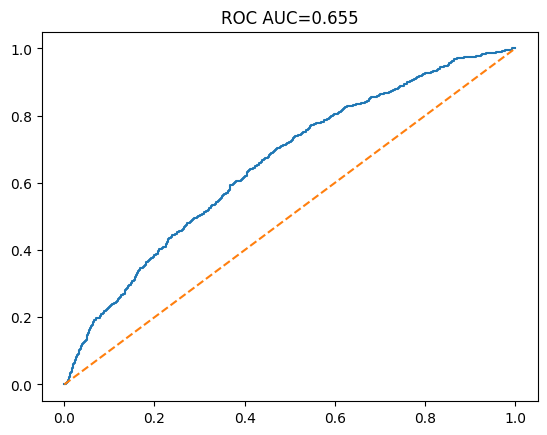

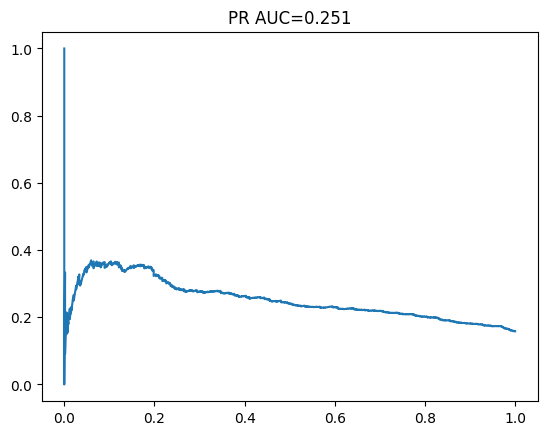

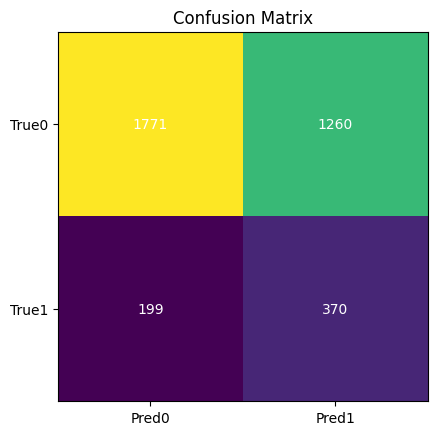

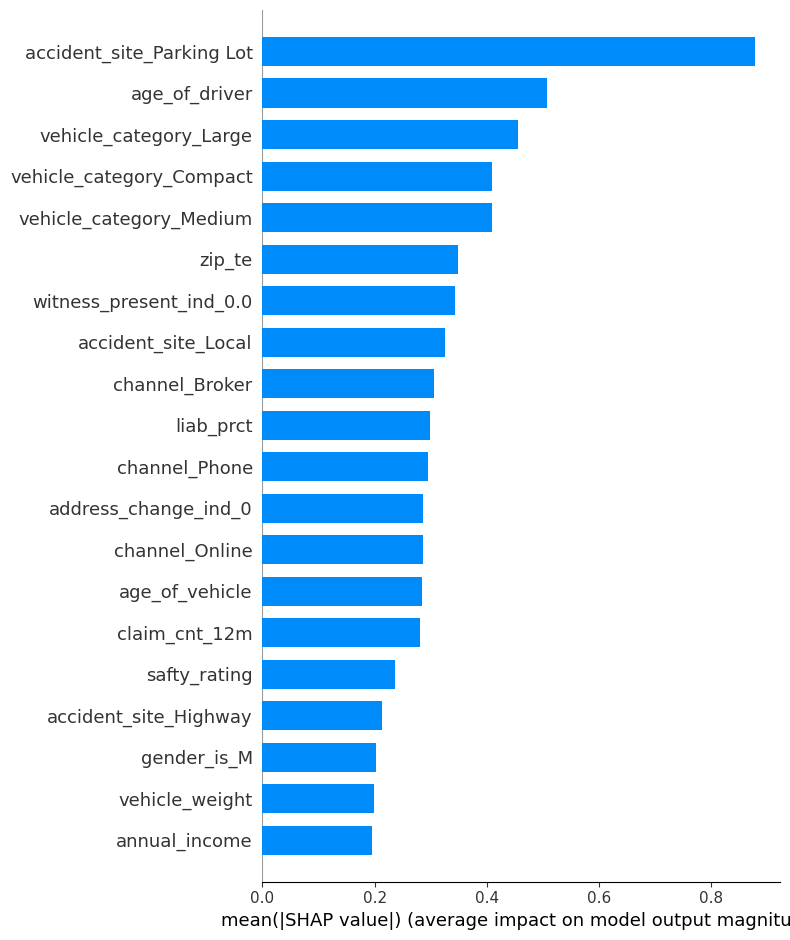

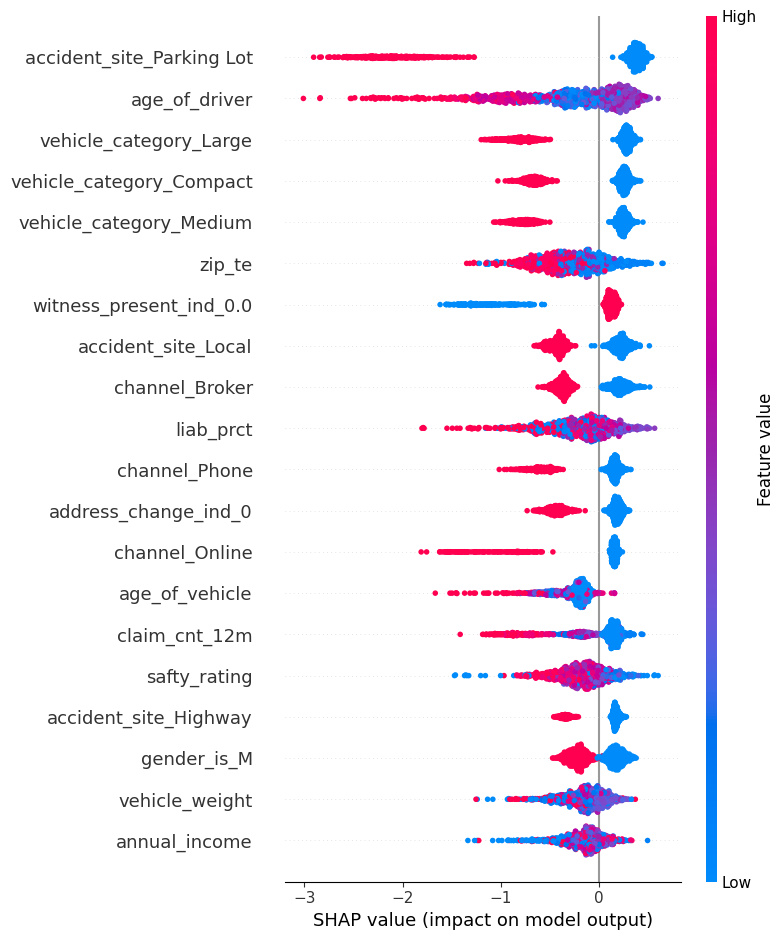

In [13]:
import os

def save_plot(fig, filename, model_name='xgboost'):
    """
    儲存圖表到 ../results/{model_name}/{filename}
    """
    path = f'../results/{model_name}'
    os.makedirs(path, exist_ok=True)
    fig.savefig(f'{path}/{filename}', dpi=300)

# -------- 圖表與 SHAP 繪製 --------
fpr, tpr, _ = roc_curve(y_val, val_prob)
fig_roc = plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--')
plt.title(f"ROC AUC={auc(fpr, tpr):.3f}")
save_plot(fig_roc, "roc_curve.png")

p, r, _ = precision_recall_curve(y_val, val_prob)
fig_pr = plt.figure()
plt.plot(r, p)
plt.title(f"PR AUC={auc(r, p):.3f}")
save_plot(fig_pr, "pr_curve.png")

fig_cm = plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xticks([0, 1], ["Pred0", "Pred1"])
plt.yticks([0, 1], ["True0", "True1"])
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white')
save_plot(fig_cm, "confusion_matrix.png")

explainer = shap.TreeExplainer(clf)
shap_vals = explainer.shap_values(X_te_df.iloc[:1000])

# SHAP 長條圖
fig_shap_bar = plt.figure()
shap.summary_plot(shap_vals, X_te_df.iloc[:1000], feature_names=feat_names, show=False, plot_type="bar")
save_plot(fig_shap_bar, "shap_summary.png")

# SHAP 蜂群圖
fig_shap_swarm = plt.figure()
shap.summary_plot(shap_vals, X_te_df.iloc[:1000], feature_names=feat_names, show=False)
save_plot(fig_shap_swarm, "shap_beeswarm.png")